In [1]:
# 비트코인 시세 예측하기
# 시계열 데이터 분석

# market price 데이터셋의 기본 정보 구하기
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Source : https://www.blockchain.com/ko.charts.market-price>timespan=60days
file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

# df의 기본 정보 확인하기
print(bitcoin_df.shape)
print(bitcoin_df.info())
bitcoin_df.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


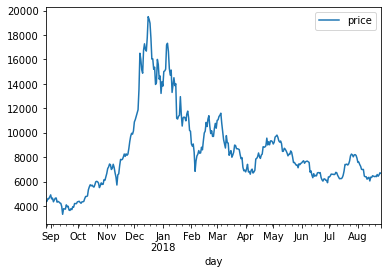

In [2]:
# price의 추이를 시각화하기

# to_datetime으로 day 피처를 시계열 피처로 변환
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 피처를 df의 index로 설정하기
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace = True)

# 일자별 비트코인 시세를 시각화하기
bitcoin_df.plot()
plt.show()

In [3]:
# ARIMA(자기회귀 누적 이동평균 모델) 분석

from statsmodels.tsa.arima_model import ARIMA # tsa = time series analysis
import statsmodels.api as sm

# (AR = 2, 차분 = 1, MA = 2) 파라미터로 ARIMA 모델 학습하기
model = ARIMA(bitcoin_df.price.values, order = (2, 1, 2))
model_fit = model.fit(trend ='c', full_output = True, disp = True)
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65815D+00    |proj g|=  2.71339D-04

At iterate    1    f=  7.65815D+00    |proj g|=  1.13634D-03

At iterate    2    f=  7.65814D+00    |proj g|=  6.34426D-04

At iterate    3    f=  7.65814D+00    |proj g|=  8.12683D-05

At iterate    4    f=  7.65814D+00    |proj g|=  4.27214D-05

At iterate    5    f=  7.65814D+00    |proj g|=  7.92255D-05

At iterate    6    f=  7.65814D+00    |proj g|=  1.57474D-04

At iterate    7    f=  7.65814D+00    |proj g|=  2.77289D-04

At iterate    8    f=  7.65814D+00    |proj g|=  4.60965D-04

At iterate    9    f=  7.65814D+00    |proj g|=  7.51310D-04

At iterate   10    f=  7.65813D+00    |proj g|=  1.08642D-03

At iterate   11    f=  7.65812D+00    |proj g|=  1.20366D-03

At iterate   12    f=  7.65812D+00    |proj g|=  1.31708D-03

At iterate   13    f=  7.6

/Users/dmis/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


<AxesSubplot:>

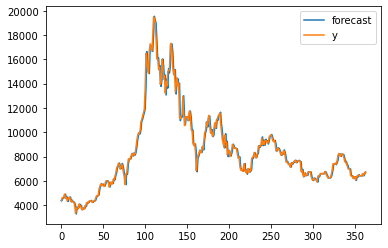

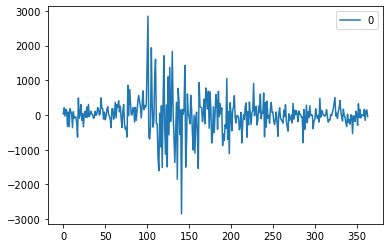

In [4]:
# ARIMA 모델 활용하기 : 모델의 성능 & 예측 결과 시각화
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과(첫 번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동 df 만들기
residuals.plot() # 잔차의 변동을 시각화 (두 번째 그래프)

# 잔차의 변동이 일정하다면 좋은 예측 모델을 학습시킨 것으로 판단할 수 있다.
# 이때, 두 번째 그래프를 보면 정말 엉망이므로 잘못 학습시킨 것으로 판단할 수 있다.

In [6]:
# ARIMA 모델 평가하기

# 1. model_fit.forecast(steps = 5)로 향후 5일의 가격을 예측하여 pred_y로 정의
# 2. '../data/market-price-test.csv'에서 실제 향후 5일의 가격을 test_y로 정의
# 3. 모델이 예측한 상한값, 하한값을 pred_y_upper, pred_y_lower로 정의
# 4. 정의한 모든 값을 비교하여 5일 동안의 상승 경향 예측이 얼마나 맞았는지 평가

forecast_data = model_fit.forecast(steps = 5) # 학습 데이터셋으로부터 5일 뒤를 예측

# test 데이터셋 불러오기
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터 (2018-08-27~2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일의 가격 데이터 (2018-08-27~2018-08-31)

pred_y_upper = []
pred_y_lower = []
for lower_upper in forecast_data[2]:
    upper = lower_upper[1]
    lower = lower_upper[0]
    pred_y_upper.append(upper)
    pred_y_lower.append(lower)

print(pred_y_upper)
print(pred_y_lower)

[7680.729134639197, 8160.84396203008, 8482.064987425128, 8775.675563273417, 9022.118429693963]
[5672.0970906422435, 5207.159818254426, 4895.417429301657, 4614.855446929424, 4379.2052008363025]


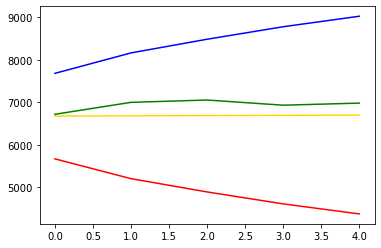

In [7]:
# 위의 내용을 그래프로 시각화하기
# 파란색 : 모델이 예상한 최고 가격(upper)
# 빨간색 : 모델이 예상한 최하 가격(lower)
# 초록색 : 실제 5일간의 가격
# 노란색 : 모델이 예상한 5일간의 가격

plt.plot(pred_y, color = "gold")
plt.plot(pred_y_lower, color = "red")
plt.plot(pred_y_upper, color = "blue")
plt.plot(test_y, color = "green")

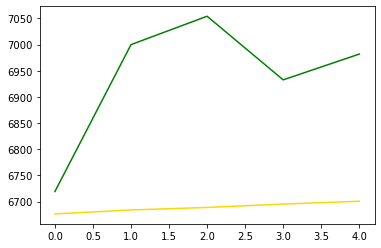

In [8]:
# 파란색, 빨간색이 각각 너무 높고 낮아, 초록색과 노란색의 차이가 명확하지 않다.
# 초록색, 노란색만 다시 그래프에 나타내보자

plt.plot(pred_y, color = "gold")
plt.plot(test_y, color = "green")